# <center><div style="font-family: Trebuchet MS; background-color: #023047; color: #ffb703; padding: 12px; line-height: 1;">Welcome To Space Race</div></center>

<font size='6'> Problem Statement: </font>

SpaceX advertises Falcon 9 rocket launches on its website with a cost of 62 million dollars, other providers cost upward of 165 million dollars each, much of the savings is because SpaceX can reuse the first stage. Therefore if we can determine if the first stage will land, we can determine the cost of a launch. This information can be used if an alternate company wants to bid against SpaceX for a rocket launch. so we will collect and make sure the data is in the correct format from an API.

<center>
    <img src="Images/SpaceToSpace.jpg" width="1000" height="600">
</center>

<font size='6'> Aim: </font>

- we will predict if the Falcon 9 first stage will land successfully. 

<font size='6'> Notebook Objectives: </font>
- Feature Engineering and Extraction
- Split the dataset into training data and test data
- Perform Data Preprocessing
- Find best Hyperparameter for Random forest, XGBoost, Logistic Regression, SVM, KNN
- Apply Ensemble learning techniques
- Find the model performs best on test data and robust to data variability

In [1]:
# Main libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Other utilities
import missingno as msno
import warnings
warnings.filterwarnings('ignore')

# Model selection
from sklearn.model_selection import (
    cross_val_score,
    train_test_split,
    GridSearchCV,
    RandomizedSearchCV
)
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import joblib

# Preprocessing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (
    StandardScaler,
    OneHotEncoder
)
from sklearn.pipeline import (
    Pipeline,
    FeatureUnion
)
from sklearn_features.transformers import DataFrameSelector

# Metrics
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    accuracy_score,
    roc_auc_score,
    roc_curve
)

# Ensemble models
from sklearn.ensemble import (
    RandomForestClassifier,
    VotingClassifier
)

# XGBoost
import xgboost as xgb

In [2]:
def model(classifier):
    # Fit the classifier on the training data
    classifier.fit(X_train_final, y_train)
    
    # Predict on the test set
    prediction = classifier.predict(X_test_final)
    
    # Print the tuned hyperparameters and the best score
    print('-'*80)
    print(f'Tuned Hyperparameters: (Best Parameters) {classifier.best_params_}')
    print(f'Best Performance During The Tuning Process: {classifier.best_score_:.2f}')
    
    # Retrieve the best model from the classifier
    best_model = classifier.best_estimator_
    
    # Perform cross-validation and calculate training accuracy
    cross_val_accuracy = cross_val_score(estimator=best_model, 
                                        X=X_train_final, y=y_train, 
                                        scoring='accuracy', cv=8, 
                                        verbose=1, n_jobs=-1)
    print(f"Cross-validation Accuracy scores: {cross_val_accuracy}")
    print(f"Mean cross-validation Accuracy score: {cross_val_accuracy.mean():.2f}")
    
    # Calculate and print accuracy on the test set
    test_accuracy = accuracy_score(y_test, prediction)
    print(f'Accuracy on Test Set: {test_accuracy:.2f}')

    
    # Perform cross-validation and calculate ROC AUC scores
    cross_val_roc_auc = cross_val_score(estimator=best_model, 
                                        X=X_train_final, y=y_train, 
                                        scoring='roc_auc', cv=8, 
                                        verbose=1, n_jobs=-1)
    print(f"Cross-validation ROC AUC scores: {cross_val_roc_auc}")
    print(f"Mean cross-validation ROC AUC score: {cross_val_roc_auc.mean():.2f}")
    
    # Predict probabilities on the test set for ROC AUC
    y_test_prob = classifier.predict_proba(X_test_final)[:, 1]
    test_roc_auc = roc_auc_score(y_test, y_test_prob)
    print(f"Test set ROC AUC: {test_roc_auc:.2f}")
    print('-'*80)
        
    # Plot ROC Curve
    fpr, tpr, thresholds = roc_curve(y_test, y_test_prob)
    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC curve (area = {test_roc_auc:.2f})')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()

    return best_model

In [3]:
def votModel(votClf):
    # Fit the VotingClassifier
    votClf.fit(X_train_final, y_train)
    
    # Predict on the test set
    prediction = votClf.predict(X_test_final)
    
    # Cross-validation accuracy scores
    cross_val_accuracy = cross_val_score(estimator=votClf, 
                                        X=X_train_final, 
                                        y=y_train, 
                                        scoring='accuracy', 
                                        cv=5, 
                                        n_jobs=-1,
                                        verbose=1)
    
    print('-'*80)
    print(f"Cross-validation Accuracy scores: {cross_val_accuracy}")
    print(f"Mean cross-validation Accuracy score: {cross_val_accuracy.mean():.2f}")

    # Accuracy on the test set
    test_accuracy = accuracy_score(y_test, prediction)
    print(f'Accuracy on Test Set: {test_accuracy:.2f}')

    # Cross-validation ROC AUC scores
    cross_val_roc_auc = cross_val_score(estimator=votClf,
                                        X=X_train_final, 
                                        y=y_train,
                                        scoring='roc_auc', 
                                        cv=5, 
                                        n_jobs=-1, 
                                        verbose=1)
    
    print(f"Cross-validation ROC AUC scores: {cross_val_roc_auc}")
    print(f"Mean cross-validation ROC AUC score: {cross_val_roc_auc.mean():.2f}")

    # ROC AUC on the test set
    y_test_proba = votClf.predict_proba(X_test_final)[:, 1]
    test_roc_auc = roc_auc_score(y_test, y_test_proba)
    print(f"Test set ROC AUC: {test_roc_auc:.2f}")
    print('-'*80)

    # Plot ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)
    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC curve (area = {test_roc_auc:.2f})')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()

In [4]:
def modelEvaluation(classifier):
    # plots the confusion matrix
    cm = confusion_matrix(y_test, classifier.predict(X_test_final))
    ax= plt.subplot()
    sns.heatmap(cm, 
                annot=True, 
                ax = ax, 
                cbar=False, 
                linecolor='black', 
                linewidths=0.4)
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('Actual labels')
    ax.set_title('Confusion Matrix')
    ax.xaxis.set_ticklabels(['did not land', 'land'])
    ax.yaxis.set_ticklabels(['did not land', 'landed']) 
    plt.show() 
    # classification report
    print(classification_report(y_test, classifier.predict(X_test_final)))

In [5]:
df = pd.read_csv('spaceX.csv')
df.head()

,FlightNumber,Date,BoosterName,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude,class
0,1,2010-06-04,Falcon 9,6123.547647,LEO,CCSFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0003,-80.577366,28.561857,0
1,2,2012-05-22,Falcon 9,525.000000,LEO,CCSFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0005,-80.577366,28.561857,0
2,3,2013-03-01,Falcon 9,677.000000,ISS,CCSFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0007,-80.577366,28.561857,0
3,4,2013-09-29,Falcon 9,500.000000,PO,VAFB SLC 4E,False Ocean,1,False,False,False,NaN,1.0,0,B1003,-120.610829,34.632093,0
4,5,2013-12-03,Falcon 9,3170.000000,GTO,CCSFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B1004,-80.577366,28.561857,0


<font size='6'> Feature Engineering and Extraction </font>

In [6]:
df['Year'] = pd.to_datetime(df['Date']).dt.year
df['Month'] = pd.to_datetime(df['Date']).dt.month
df['Day'] = pd.to_datetime(df['Date']).dt.day
df = df.drop(columns='Date')

In [7]:
def map_months(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Autumn'

df['Season'] = df['Month'].apply(map_months)

In [8]:
df.drop(columns=['BoosterName', 'Outcome', 'Longitude', 'Latitude'], inplace=True)

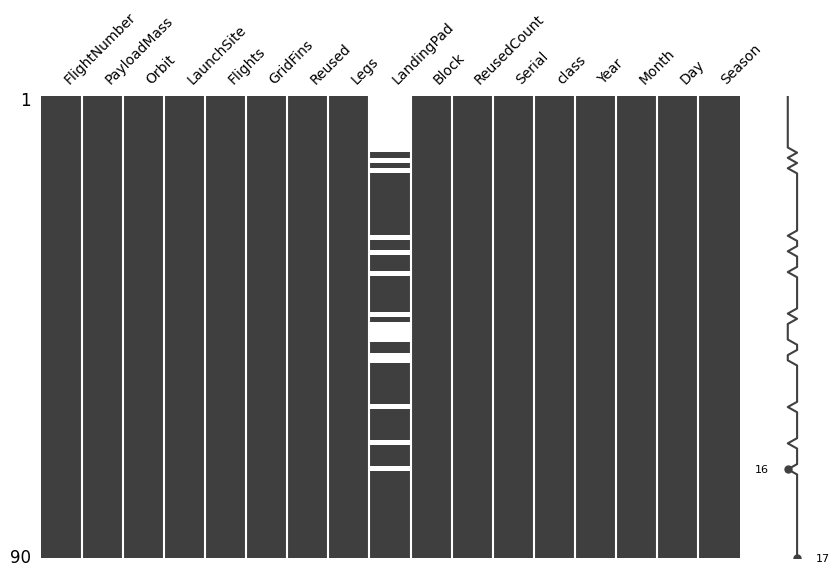

In [9]:
# checking null values
msno.matrix(df, figsize=(10, 6), fontsize=10)
plt.show()

- As you can see there are null values in "LandingPad" column which will be handeled later

<font size='6'> Checking The correlation between variables </font>

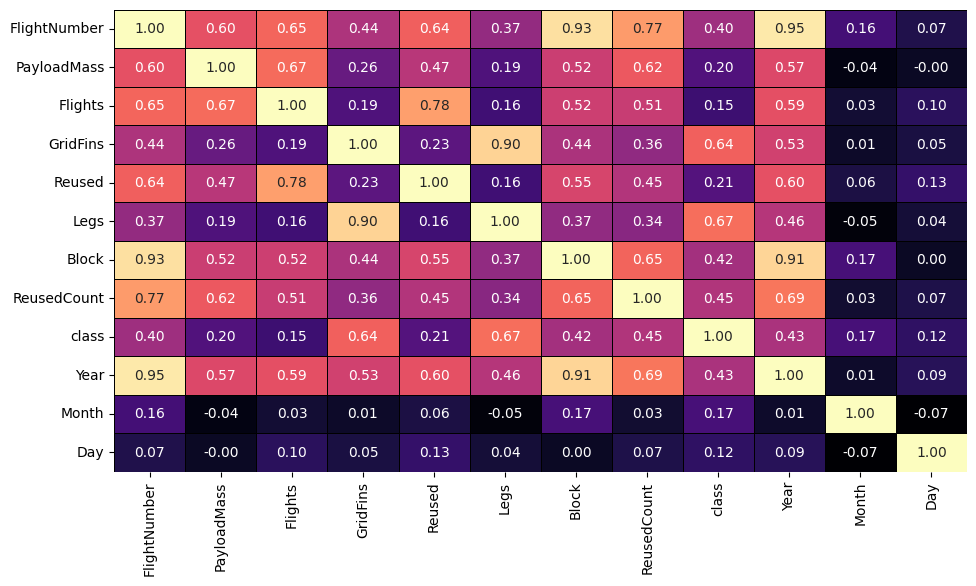

In [10]:
plt.figure(figsize=(11, 6))
corrMat = df.corr(numeric_only=True)
sns.heatmap(
            corrMat, 
            annot=True, 
            cmap='magma', 
            fmt='.2f', 
            cbar=False, 
            linecolor='black', 
            linewidths=0.4
            )
plt.show()

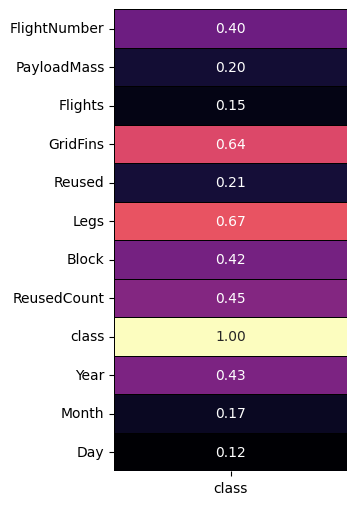

In [38]:
targetCorr = corrMat[['class']]
plt.figure(figsize=(3, 6))
sns.heatmap(targetCorr, 
            cbar=False, 
            annot=True, 
            fmt='.2f', 
            cmap='magma', 
            linecolor='black', 
            linewidths=0.4
            )

plt.show()

<font size='6'> Split The Dataset </font>

In [12]:
## split the dataset into features and target
X = df.drop(columns=['class'])  # features
y = df['class']  # target

In [13]:
## split the dataset into training set and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, shuffle=True)

In [14]:
# numerical columns
numCols = X_train.select_dtypes(include=['number']).columns
# categorical columns
catCols = X_train.select_dtypes(include=['category', 'object']).columns

In [15]:
# Define a pipeline for preprocessing

# numerical pipeline
numPipeline = Pipeline(
    [
        ('selector', DataFrameSelector(numCols)), 
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ]
    )

# categorical pipeline
catgPipeline = Pipeline(
    [
        ('selector', DataFrameSelector(catCols)),
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('OHE', OneHotEncoder(sparse=False, drop='first', handle_unknown='ignore'))
    ]
)

# Getting all together
totalPipeline = FeatureUnion(
    transformer_list=[
        ('numPipeline', numPipeline), 
        ('catgPipeline', catgPipeline)
    ]
)

In [16]:
X_train_final = totalPipeline.fit_transform(X_train)
X_test_final = totalPipeline.transform(X_test)

In [17]:
X_train_final, X_test_final 

(array([[-0.55651247, -0.03499514, -0.66079284, ...,  1.        ,
          0.        ,  0.        ],
        [-0.44178528,  0.70282728, -0.66079284, ...,  0.        ,
          1.        ,  0.        ],
        [-1.28311798, -0.80312471, -0.66079284, ...,  0.        ,
          0.        ,  1.        ],
        ...,
        [ 1.01142574,  1.95691637,  1.71098145, ...,  0.        ,
          0.        ,  1.        ],
        [-1.1683908 , -0.31988238, -0.66079284, ...,  1.        ,
          0.        ,  0.        ],
        [ 0.24657783, -0.79998949,  0.12979859, ...,  0.        ,
          1.        ,  0.        ]]),
 array([[-0.17408852, -0.53036033, -0.66079284, ...,  0.        ,
          0.        ,  0.        ],
        [-0.86245163, -0.83196876, -0.66079284, ...,  0.        ,
          1.        ,  0.        ],
        [ 0.39954741,  0.17192956, -0.66079284, ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [ 1.08791053,  1.95691637,  0.92039002, ...,  

<font size='6'> Modeling & Hyperparameter Tuning </font>

- RandomForest

In [18]:

weight = df['class'].value_counts().values / np.sum(df['class'].value_counts().values)
new_weight = weight[::-1]
finalWeight = {df['class'].value_counts().index[0]:new_weight[0],
                df['class'].value_counts().index[1]:new_weight[1]}

Fitting 8 folds for each of 100 candidates, totalling 800 fits
--------------------------------------------------------------------------------
Tuned Hyperparameters: (Best Parameters) {'n_estimators': 300, 'min_samples_split': 12, 'min_samples_leaf': 3, 'max_features': 'log2', 'max_depth': 25, 'criterion': 'entropy'}
Best Performance During The Tuning Process: 0.86


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   8 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Cross-validation Accuracy scores: [1.         0.66666667 0.88888889 0.75       1.         0.75
 0.75       0.75      ]
Mean cross-validation Accuracy score: 0.82
Accuracy on Test Set: 0.87
Cross-validation ROC AUC scores: [1.         0.77777778 0.83333333 0.86666667 1.         1.
 0.73333333 0.73333333]
Mean cross-validation ROC AUC score: 0.87
Test set ROC AUC: 0.77
--------------------------------------------------------------------------------


[Parallel(n_jobs=-1)]: Done   4 out of   8 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    0.4s finished


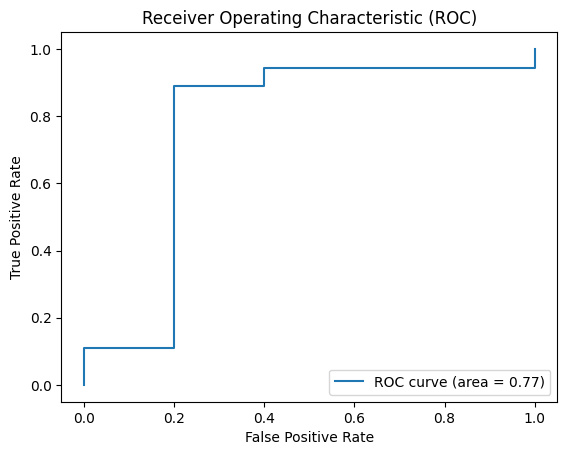

RandomForestClassifier(class_weight={0: 0.6666666666666666,
                                     1: 0.3333333333333333},
                       criterion='entropy', max_depth=25, max_features='log2',
                       min_samples_leaf=3, min_samples_split=12,
                       n_estimators=300)

In [19]:
parameters = {
    'n_estimators': [300, 350, 400],
    'max_depth': [None, 5, 10, 15, 20, 25, 30],
    'max_features': ['sqrt', 'log2'],
    'min_samples_split': [2, 5, 7, 10, 12, 15, 18, 20],
    'min_samples_leaf': [1, 2, 3, 4, 6, 8],
    'criterion': ['gini', 'entropy']
}
forest_clf = RandomForestClassifier(class_weight=finalWeight)
forestCV = RandomizedSearchCV(estimator=forest_clf, 
                                param_distributions=parameters, 
                                cv=8, 
                                n_iter=100,
                                scoring='accuracy', 
                                n_jobs=-1, 
                                verbose=5,
                                random_state=42
                                )
model(forestCV)

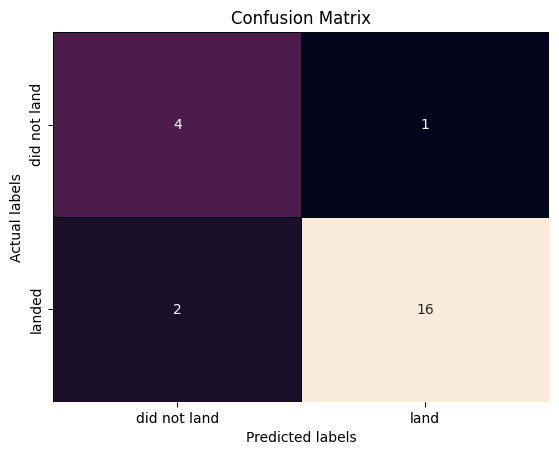

              precision    recall  f1-score   support

           0       0.67      0.80      0.73         5
           1       0.94      0.89      0.91        18

    accuracy                           0.87        23
   macro avg       0.80      0.84      0.82        23
weighted avg       0.88      0.87      0.87        23



In [20]:
modelEvaluation(forestCV)

- XGBoost

Fitting 8 folds for each of 150 candidates, totalling 1200 fits
--------------------------------------------------------------------------------
Tuned Hyperparameters: (Best Parameters) {'subsample': 0.9, 'reg_lambda': 1.0, 'reg_alpha': 1.0, 'n_estimators': 400, 'min_child_weight': 1, 'max_depth': 6, 'learning_rate': 0.1, 'gamma': 0.5, 'colsample_bytree': 0.8}
Best Performance During The Tuning Process: 0.85
Cross-validation Accuracy scores: [1.         0.66666667 0.88888889 0.875      1.         0.75
 0.875      0.75      ]
Mean cross-validation Accuracy score: 0.85
Accuracy on Test Set: 0.87


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Cross-validation ROC AUC scores: [1.         0.88888889 0.88888889 1.         1.         1.
 0.76666667 0.8       ]
Mean cross-validation ROC AUC score: 0.92
Test set ROC AUC: 0.86
--------------------------------------------------------------------------------


[Parallel(n_jobs=-1)]: Done   4 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    0.0s finished


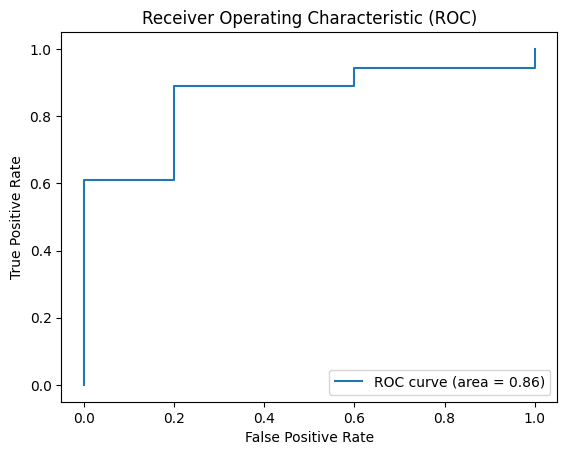

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=0.5, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=1, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=400,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [21]:
param_grid = {
    'n_estimators': [350, 400, 450],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [4, 5, 6],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'reg_alpha': [0.1, 0.5, 1.0],
    'reg_lambda': [0.1, 0.5, 1.0],
    'gamma': [0.5, 1.0, 1.5],
    'min_child_weight': [1, 3, 5]
}

xgb_clf = xgb.XGBClassifier(objective='binary:logistic', 
                            eval_metric='logloss')
xbgRCV = RandomizedSearchCV(estimator=xgb_clf, 
                            param_distributions=param_grid, 
                            scoring='accuracy', 
                            n_iter=150, 
                            cv=8,
                            n_jobs=-1, 
                            random_state=42,
                            verbose=1)
model(classifier=xbgRCV)

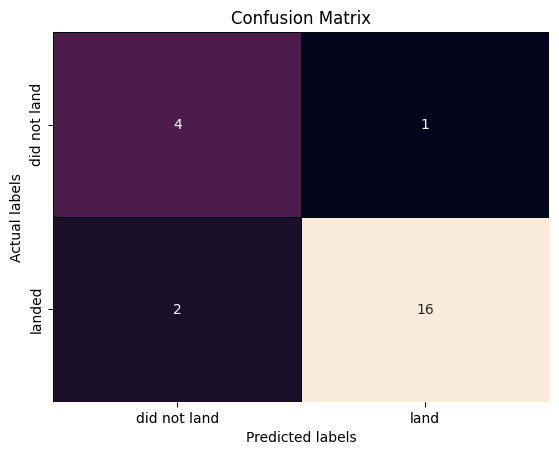

              precision    recall  f1-score   support

           0       0.67      0.80      0.73         5
           1       0.94      0.89      0.91        18

    accuracy                           0.87        23
   macro avg       0.80      0.84      0.82        23
weighted avg       0.88      0.87      0.87        23



In [22]:
modelEvaluation(xbgRCV)

- Voting classifier for Random forest and XGBoost

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


--------------------------------------------------------------------------------
Cross-validation Accuracy scores: [0.78571429 0.92857143 0.92307692 0.84615385 0.76923077]
Mean cross-validation Accuracy score: 0.85
Accuracy on Test Set: 0.87
Cross-validation ROC AUC scores: [0.88888889 0.88888889 0.975      1.         0.75      ]
Mean cross-validation ROC AUC score: 0.90
Test set ROC AUC: 0.78
--------------------------------------------------------------------------------


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.4s finished


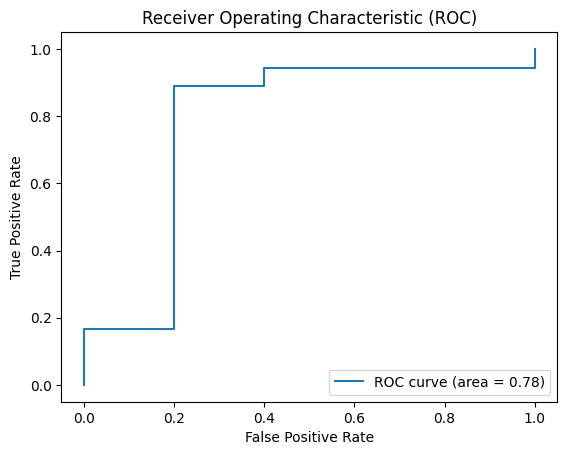

In [23]:
voting_clf = VotingClassifier(estimators=
                                [
                                ('BestXgb', xbgRCV.best_estimator_),
                                ('BestForest', forestCV.best_estimator_)
                                ],
                                voting='soft')
votModel(voting_clf)

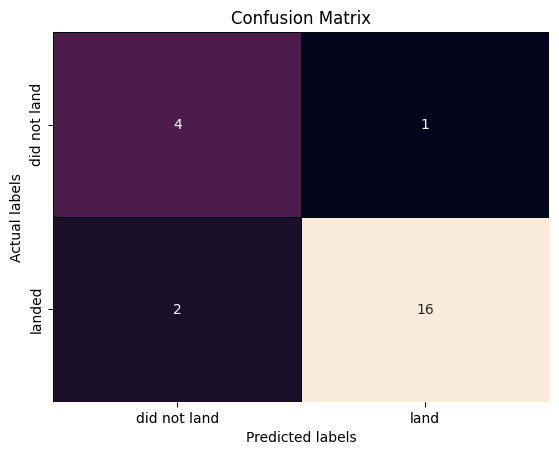

              precision    recall  f1-score   support

           0       0.67      0.80      0.73         5
           1       0.94      0.89      0.91        18

    accuracy                           0.87        23
   macro avg       0.80      0.84      0.82        23
weighted avg       0.88      0.87      0.87        23



In [24]:
modelEvaluation(voting_clf)

- Logistic Regression

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
--------------------------------------------------------------------------------
Tuned Hyperparameters: (Best Parameters) {'penalty': 'l2', 'C': 0.79}
Best Performance During The Tuning Process: 0.76
Cross-validation Accuracy scores: [0.88888889 0.66666667 0.77777778 0.75       0.875      0.75
 0.75       0.625     ]
Mean cross-validation Accuracy score: 0.76
Accuracy on Test Set: 0.78
Cross-validation ROC AUC scores: [1.         0.83333333 0.83333333 0.8        1.         0.86666667
 0.73333333 0.73333333]
Mean cross-validation ROC AUC score: 0.85
Test set ROC AUC: 0.80
--------------------------------------------------------------------------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    0.0s finished


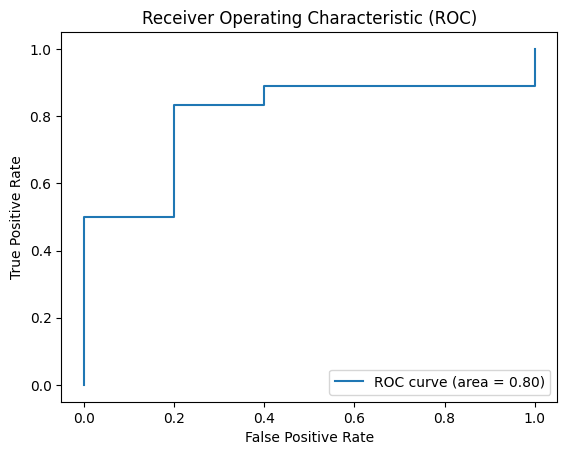

LogisticRegression(C=0.79,
                   class_weight={0: 0.6666666666666666, 1: 0.3333333333333333})

In [25]:
parameters = {
    "C":np.arange(0.01, 1, 0.01),
    "penalty": ['l1', 'l2']
}

lr_clf = LogisticRegression(solver='lbfgs', class_weight=finalWeight)
lrRCV = RandomizedSearchCV(estimator=lr_clf, 
                            param_distributions=parameters,
                            scoring='accuracy', 
                            cv=10,
                            n_iter=100,
                            n_jobs=-1, 
                            verbose=1,
                            random_state=123)
model(lrRCV)

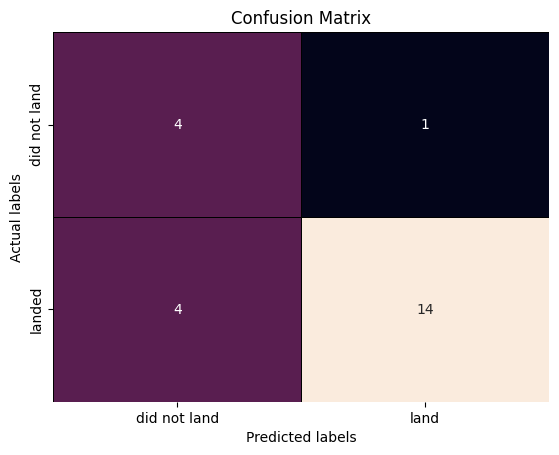

              precision    recall  f1-score   support

           0       0.50      0.80      0.62         5
           1       0.93      0.78      0.85        18

    accuracy                           0.78        23
   macro avg       0.72      0.79      0.73        23
weighted avg       0.84      0.78      0.80        23



In [26]:
modelEvaluation(lrRCV)

- Support Vector Classifier

Fitting 10 folds for each of 200 candidates, totalling 2000 fits
--------------------------------------------------------------------------------
Tuned Hyperparameters: (Best Parameters) {'kernel': 'poly', 'gamma': 0.046415888336127774, 'degree': 3, 'coef0': 0.75, 'C': 10.0}
Best Performance During The Tuning Process: 0.88
Cross-validation Accuracy scores: [1.         0.88888889 0.88888889 0.75       1.         0.75
 0.75       0.625     ]
Mean cross-validation Accuracy score: 0.83
Accuracy on Test Set: 0.87
Cross-validation ROC AUC scores: [1.         0.94444444 0.83333333 0.86666667 1.         0.86666667
 0.73333333 0.86666667]
Mean cross-validation ROC AUC score: 0.89
Test set ROC AUC: 0.87
--------------------------------------------------------------------------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    0.0s finished


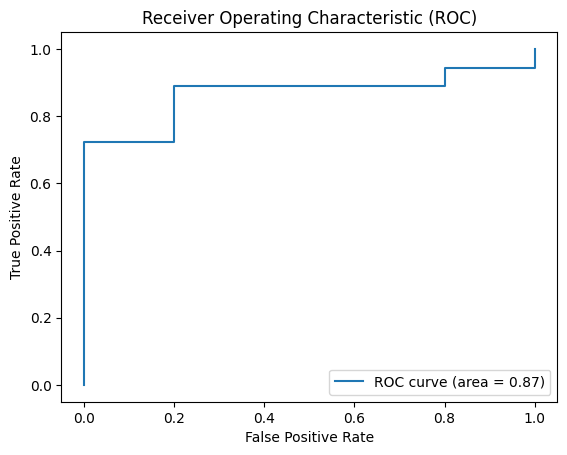

SVC(C=10.0, class_weight={0: 0.6666666666666666, 1: 0.3333333333333333},
    coef0=0.75, gamma=0.046415888336127774, kernel='poly', probability=True)

In [27]:
parameters = {
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'C': np.logspace(-3, 3, 10),
    'gamma': np.logspace(-4, 2, 10),
    'degree': [2, 3, 4, 5], 
    'coef0': np.linspace(0, 1, 5),  
}

svc_clf = SVC(probability=True, class_weight=finalWeight)
svc_cv = RandomizedSearchCV(
    estimator=svc_clf, 
    param_distributions=parameters, 
    scoring='accuracy',
    n_iter=200,
    cv=10, 
    n_jobs=-1, 
    verbose=1,
    random_state=42
)

model(svc_cv)

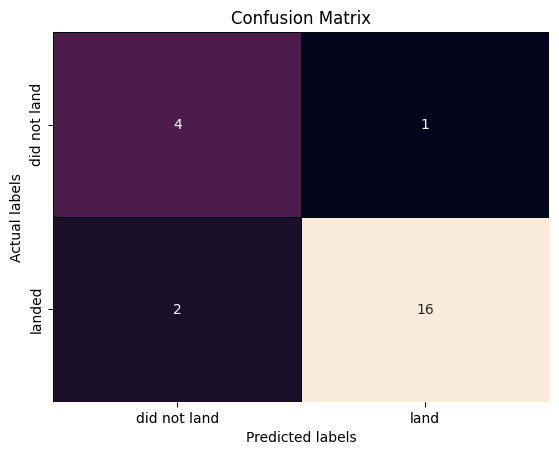

              precision    recall  f1-score   support

           0       0.67      0.80      0.73         5
           1       0.94      0.89      0.91        18

    accuracy                           0.87        23
   macro avg       0.80      0.84      0.82        23
weighted avg       0.88      0.87      0.87        23



In [28]:
modelEvaluation(svc_cv)

- K-Nearest Neighbors

Fitting 15 folds for each of 200 candidates, totalling 3000 fits
--------------------------------------------------------------------------------
Tuned Hyperparameters: (Best Parameters) {'algorithm': 'auto', 'n_neighbors': 21, 'p': 1}
Best Performance During The Tuning Process: 0.76
Cross-validation Accuracy scores: [0.88888889 0.66666667 0.88888889 0.75       0.75       0.625
 0.875      0.625     ]
Mean cross-validation Accuracy score: 0.76
Accuracy on Test Set: 0.87
Cross-validation ROC AUC scores: [0.975      0.69444444 0.83333333 0.86666667 0.96666667 0.86666667
 0.7        0.73333333]
Mean cross-validation ROC AUC score: 0.83
Test set ROC AUC: 0.80
--------------------------------------------------------------------------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    0.0s finished


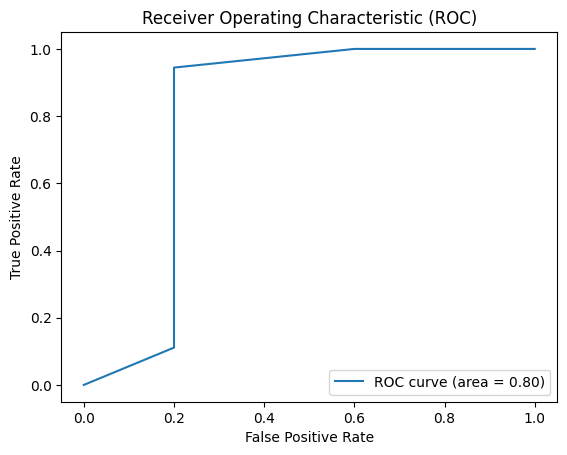

KNeighborsClassifier(n_neighbors=21, p=1)

In [29]:
parameters = {'n_neighbors':[int(x) for x in np.linspace(10, 21, 25)],
                'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                'p': [1,2]}
knn_clf = KNeighborsClassifier()
knnCV = GridSearchCV(estimator=knn_clf, 
                    param_grid=parameters,
                    scoring='accuracy', 
                    cv=15, 
                    n_jobs=-1, 
                    verbose=1)
model(knnCV)

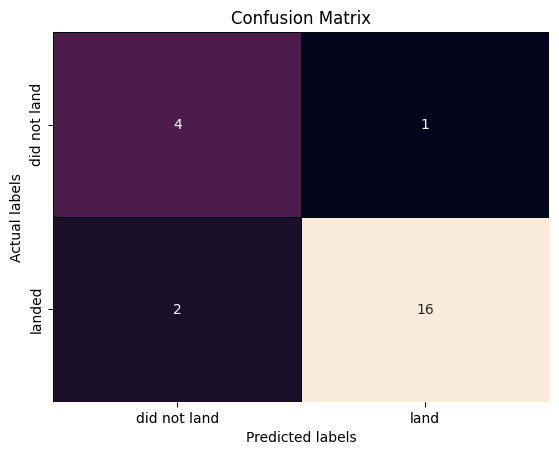

              precision    recall  f1-score   support

           0       0.67      0.80      0.73         5
           1       0.94      0.89      0.91        18

    accuracy                           0.87        23
   macro avg       0.80      0.84      0.82        23
weighted avg       0.88      0.87      0.87        23



In [30]:
modelEvaluation(knnCV)

- Voting classifier for XGB, SVC and KNN

--------------------------------------------------------------------------------
Cross-validation Accuracy scores: [0.85714286 0.92857143 0.84615385 0.84615385 0.69230769]
Mean cross-validation Accuracy score: 0.83
Accuracy on Test Set: 0.87


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished


Cross-validation ROC AUC scores: [0.93333333 0.88888889 1.         1.         0.775     ]
Mean cross-validation ROC AUC score: 0.92
Test set ROC AUC: 0.90
--------------------------------------------------------------------------------


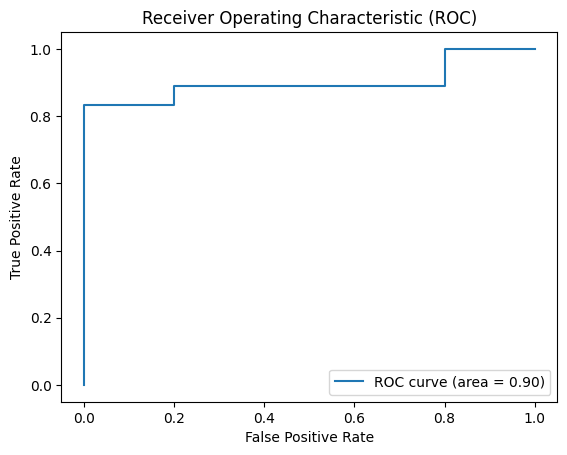

In [31]:
votingThr = VotingClassifier(estimators=
                                [
                                    ('BestXgb', xbgRCV.best_estimator_), 
                                    ('BestCvc', svc_cv.best_estimator_),  
                                    ('BestKnn', knnCV.best_estimator_),
                                ], 
                                voting='soft')
votModel(votingThr)

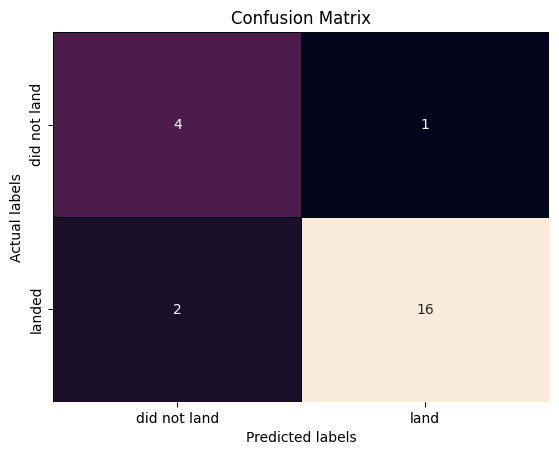

              precision    recall  f1-score   support

           0       0.67      0.80      0.73         5
           1       0.94      0.89      0.91        18

    accuracy                           0.87        23
   macro avg       0.80      0.84      0.82        23
weighted avg       0.88      0.87      0.87        23



In [32]:
modelEvaluation(votingThr)

<font size='6'> Based on the the previous results
The Best Model is "votingThr" </font>

In [33]:
# Save the model
joblib.dump(votingThr, "Models/paceX_BestModel.pkl")

['Models/paceX_BestModel.pkl']

# <center><div style="font-family: Trebuchet MS; background-color: #023047; color: #ffb703; padding: 12px; line-height: 1;">By: Mohamed Ghannnam</div></center><center><div style="font-family: Trebuchet MS; background-color: #023047; color: #ffb703; padding: 12px; line-height: 1;">Thank You!</div></center>

linkedin: [https://www.linkedin.com/in/mohamedghannnam/](https://www.linkedin.com/in/mohamedghannnam/)